# Continuous Soft Prompt Grid Search Results Analysis

This notebook analyzes the continuous soft prompt grid search results to find the best learning rate for both adversarial and non-adversarial cases.


In [7]:
import json
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
from pathlib import Path

plt.style.use('seaborn-v0_8')
%matplotlib inline


In [8]:
# Base directory
base_dir = "/mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_gridsearch"

print(f"Results directory: {base_dir}")


Results directory: /mnt/polished-lake/home/annabelma/other/results_fixed/continuous/continuous_soft_prompt_gridsearch


In [9]:
def load_all_histories(directory):
    """Load all history JSON files from a directory."""
    histories = {}
    
    # Find all history files
    history_files = glob.glob(os.path.join(directory, "history_*.json"))
    
    for filepath in history_files:
        # Parse filename: history_adversarial_{True/False}_lr_{lr}_promptlen_{promptlen}.json
        filename = os.path.basename(filepath)
        match = re.match(r"history_adversarial_(True|False)_lr_([0-9.e-]+)_promptlen_(\d+)\.json", filename)
        
        if match:
            adversarial_str = match.group(1)
            adversarial = adversarial_str == "True"
            lr_val = float(match.group(2))
            prompt_len = int(match.group(3))
            
            with open(filepath, 'r') as f:
                history = json.load(f)
            
            key = (adversarial, lr_val, prompt_len)
            histories[key] = history
            print(f"Loaded: adversarial={adversarial}, lr={lr_val}, prompt_len={prompt_len}")
    
    return histories


In [10]:
# Load histories
print("Loading all histories...")
all_histories = load_all_histories(base_dir)

# Separate by adversarial flag
non_adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if not adv}
adv_histories = {(adv, lr, pl): h for (adv, lr, pl), h in all_histories.items() if adv}

print(f"\nNon-adversarial: {len(non_adv_histories)} runs")
print(f"Adversarial: {len(adv_histories)} runs")


Loading all histories...
Loaded: adversarial=False, lr=0.0001, prompt_len=10
Loaded: adversarial=False, lr=0.001, prompt_len=10
Loaded: adversarial=False, lr=1e-05, prompt_len=10
Loaded: adversarial=False, lr=1e-06, prompt_len=10
Loaded: adversarial=True, lr=0.0001, prompt_len=10
Loaded: adversarial=True, lr=0.001, prompt_len=10
Loaded: adversarial=True, lr=1e-05, prompt_len=10
Loaded: adversarial=True, lr=1e-06, prompt_len=10

Non-adversarial: 4 runs
Adversarial: 4 runs


In [11]:
def plot_learning_curves(histories, title_prefix=""):
    """Plot learning curves for continuous soft prompts, grouped by adversarial flag."""
    
    if not histories:
        print("No histories to plot")
        return []
    
    # Group by prompt length (usually just one value, but handle multiple)
    prompt_lengths = sorted(set(k[2] for k in histories.keys()))
    lr_values = sorted(set(k[1] for k in histories.keys()))
    
    figs = []
    
    for prompt_len in prompt_lengths:
        # Filter histories for this prompt length
        pl_histories = {(adv, lr, pl): h for (adv, lr, pl), h in histories.items() if pl == prompt_len}
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(f"{title_prefix}Continuous Soft Prompt Learning Curves - Prompt Length={prompt_len}", fontsize=16, fontweight='bold')
        
        # Plot 1: Validation Accuracy
        ax1 = axes[0, 0]
        for (adv, lr, pl), history in sorted(pl_histories.items()):
            epochs = range(1, len(history['val_acc']) + 1)
            ax1.plot(epochs, history['val_acc'], marker='o', label=f"lr={lr:.0e}", linewidth=2, markersize=6)
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Validation Accuracy')
        ax1.set_title(f'Continuous Soft Prompt: Validation Accuracy (Prompt Length={prompt_len})')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: Training Loss
        ax2 = axes[0, 1]
        for (adv, lr, pl), history in sorted(pl_histories.items()):
            epochs = range(1, len(history['train_joint']) + 1)
            ax2.plot(epochs, history['train_joint'], marker='o', label=f"lr={lr:.0e}", linewidth=2, markersize=6)
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Training Joint Loss')
        ax2.set_title(f'Continuous Soft Prompt: Training Joint Loss (Prompt Length={prompt_len})')
        ax2.legend(fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Validation Loss
        ax3 = axes[0, 2]
        for (adv, lr, pl), history in sorted(pl_histories.items()):
            epochs = range(1, len(history['val_loss']) + 1)
            ax3.plot(epochs, history['val_loss'], marker='o', label=f"lr={lr:.0e}", linewidth=2, markersize=6)
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Validation Loss')
        ax3.set_title(f'Continuous Soft Prompt: Validation Loss (Prompt Length={prompt_len})')
        ax3.legend(fontsize=10)
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Prompt Norm
        ax4 = axes[1, 0]
        for (adv, lr, pl), history in sorted(pl_histories.items()):
            if 'prompt_norm' in history:
                epochs = range(1, len(history['prompt_norm']) + 1)
                ax4.plot(epochs, history['prompt_norm'], marker='o', label=f"lr={lr:.0e}", linewidth=2, markersize=6)
        ax4.set_xlabel('Epoch')
        ax4.set_ylabel('Soft Prompt Norm (L2)')
        ax4.set_title(f'Continuous Soft Prompt: Prompt Norm (Prompt Length={prompt_len})')
        ax4.legend(fontsize=10)
        ax4.grid(True, alpha=0.3)
        
        # Plot 5: Best validation accuracy per learning rate
        ax5 = axes[1, 1]
        lrs = []
        best_accs = []
        for (adv, lr, pl), history in sorted(pl_histories.items()):
            best_acc = max(history['val_acc'])
            lrs.append(f"lr={lr:.0e}")
            best_accs.append(best_acc)
        
        bars = ax5.bar(range(len(lrs)), best_accs, alpha=0.7, edgecolor='black')
        ax5.set_xticks(range(len(lrs)))
        ax5.set_xticklabels(lrs, rotation=45, ha='right', fontsize=10)
        ax5.set_ylabel('Best Validation Accuracy')
        ax5.set_title(f'Continuous Soft Prompt: Best Val Acc by LR (Prompt Length={prompt_len})')
        ax5.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, (bar, acc) in enumerate(zip(bars, best_accs)):
            height = bar.get_height()
            ax5.text(bar.get_x() + bar.get_width()/2., height,
                    f'{acc:.4f}',
                    ha='center', va='bottom', fontsize=9, fontweight='bold')
        
        # Plot 6: True vs False Accuracy
        ax6 = axes[1, 2]
        lrs_sorted = sorted(set(k[1] for k in pl_histories.keys()))
        true_accs = []
        false_accs = []
        for lr in lrs_sorted:
            # Find history for this lr
            for (adv, l, pl), history in pl_histories.items():
                if l == lr:
                    true_accs.append(max(history['val_acc_true']))
                    false_accs.append(max(history['val_acc_false']))
                    break
        
        x = np.arange(len(lrs_sorted))
        width = 0.35
        ax6.bar(x - width/2, true_accs, width, label='True (yes)', alpha=0.7, edgecolor='black')
        ax6.bar(x + width/2, false_accs, width, label='False (no)', alpha=0.7, edgecolor='black')
        ax6.set_xlabel('Learning Rate')
        ax6.set_ylabel('Best Accuracy')
        ax6.set_title(f'Continuous Soft Prompt: Best Acc by Label Type (Prompt Length={prompt_len})')
        ax6.set_xticks(x)
        ax6.set_xticklabels([f"{lr:.0e}" for lr in lrs_sorted], rotation=45, ha='right', fontsize=10)
        ax6.legend()
        ax6.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        figs.append(fig)
    
    return figs


Plotting non-adversarial continuous soft prompt learning curves...


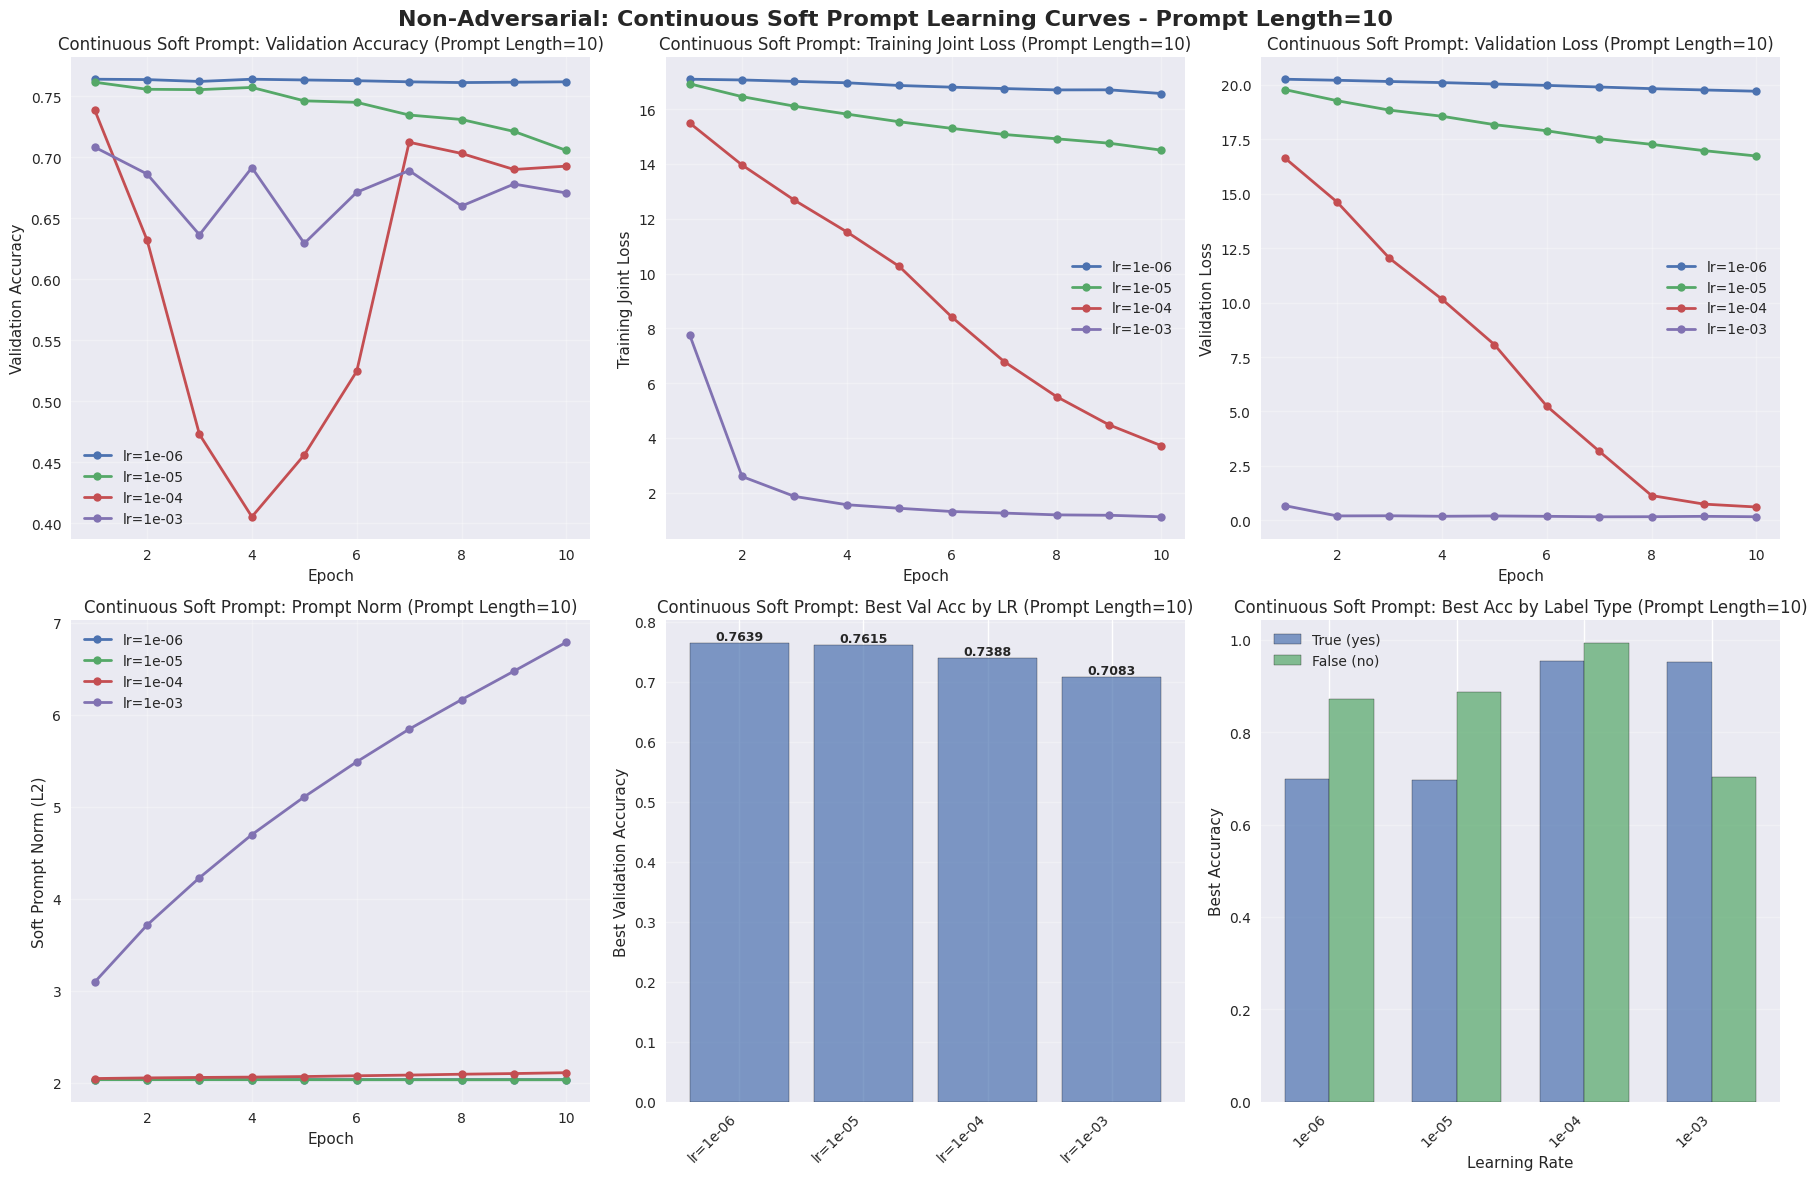

In [14]:
# Plot non-adversarial learning curves
print("Plotting non-adversarial continuous soft prompt learning curves...")
if non_adv_histories:
    figs_non_adv = plot_learning_curves(non_adv_histories, title_prefix="Non-Adversarial: ")
    for fig in figs_non_adv:
        plt.show()
else:
    print("No non-adversarial continuous soft prompt histories found")


Plotting adversarial continuous soft prompt learning curves...


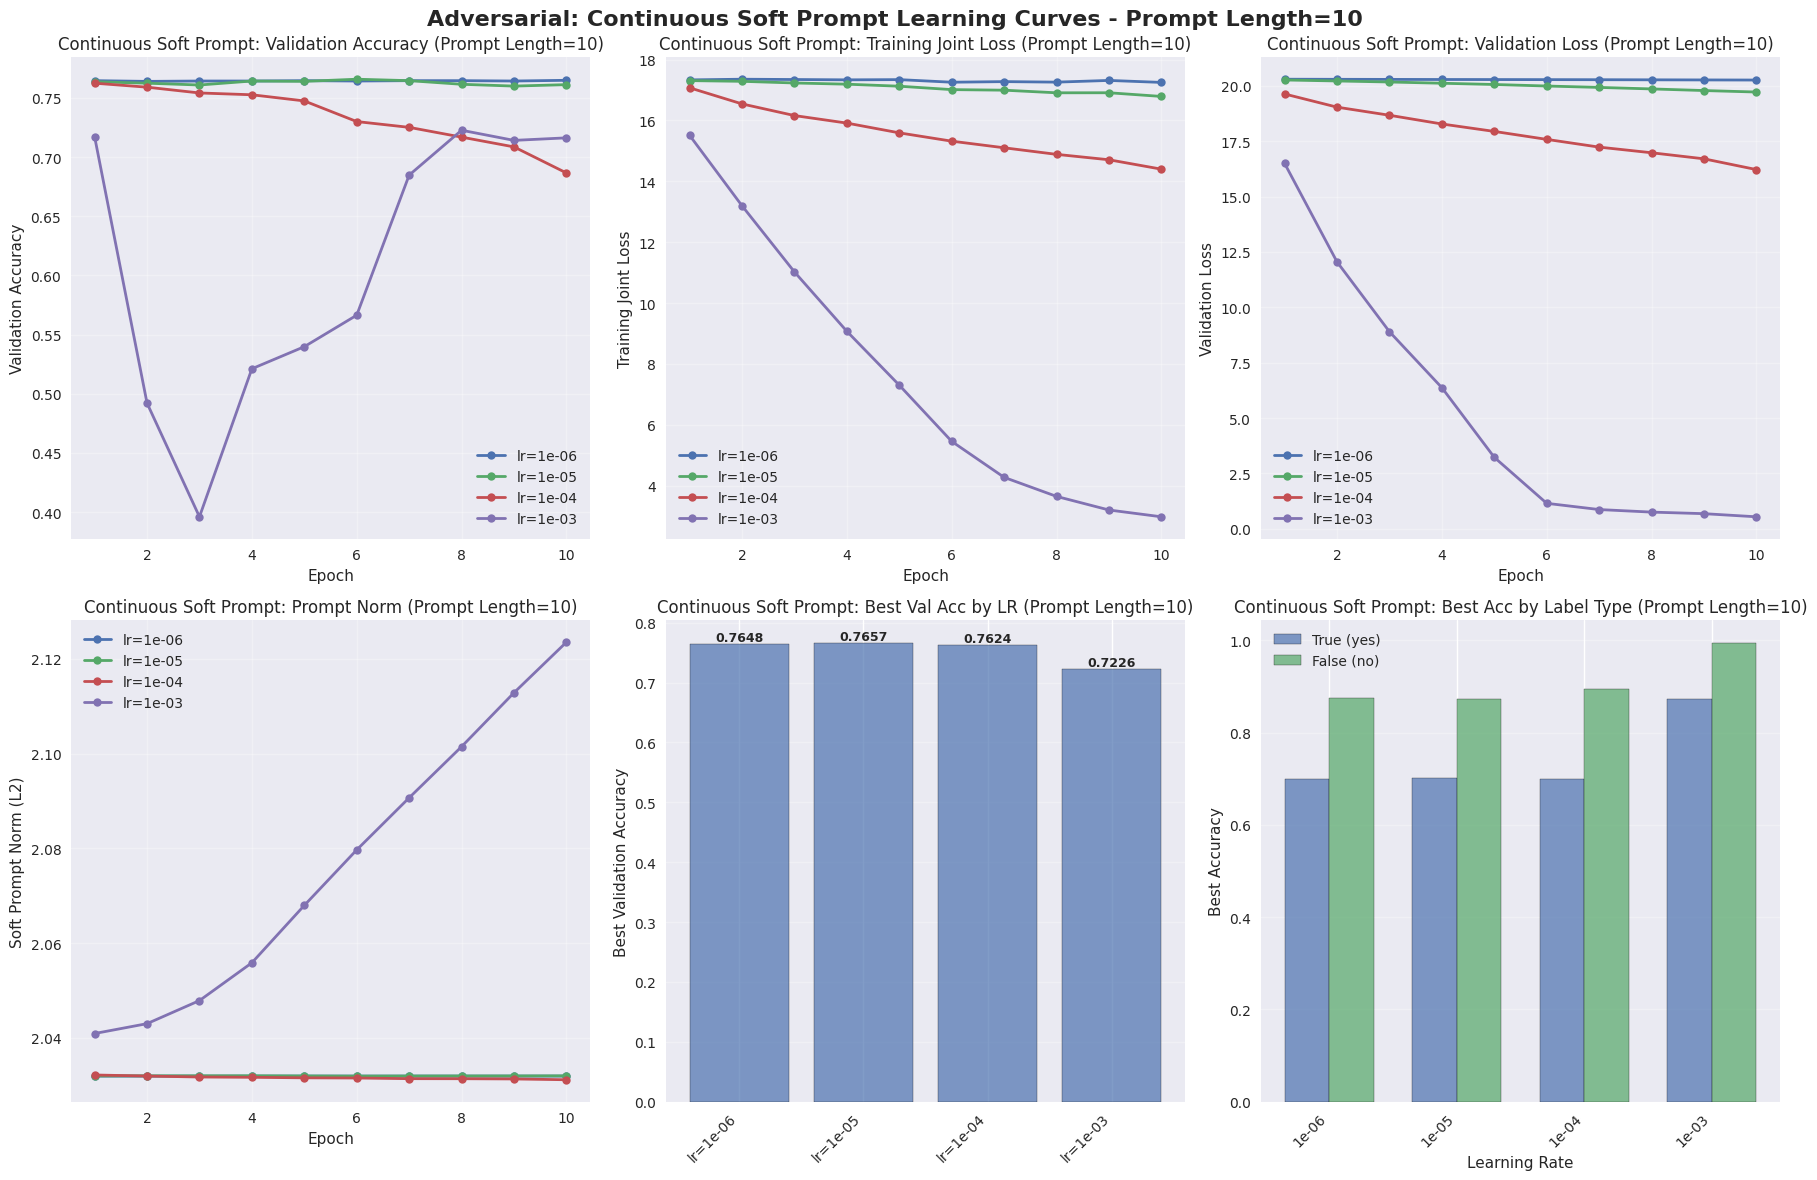

In [15]:
# Plot adversarial learning curves
print("Plotting adversarial continuous soft prompt learning curves...")
if adv_histories:
    figs_adv = plot_learning_curves(adv_histories, title_prefix="Adversarial: ")
    for fig in figs_adv:
        plt.show()
else:
    print("No adversarial continuous soft prompt histories found")


In [16]:
# Summary table
print("\n" + "=" * 80)
print("CONTINUOUS SOFT PROMPT: SUMMARY TABLE")
print("=" * 80)

summary_data = []

for (adv, lr, pl), history in sorted(all_histories.items()):
    best_val_acc = max(history['val_acc'])
    final_val_acc = history['val_acc'][-1]
    best_true_acc = max(history['val_acc_true'])
    best_false_acc = max(history['val_acc_false'])
    final_prompt_norm = history['prompt_norm'][-1] if 'prompt_norm' in history else None
    
    summary_data.append({
        'Adversarial': 'Yes' if adv else 'No',
        'Learning Rate': f"{lr:.0e}",
        'Prompt Length': pl,
        'Best Val Acc': best_val_acc,
        'Final Val Acc': final_val_acc,
        'Best True Acc': best_true_acc,
        'Best False Acc': best_false_acc,
        'Final Prompt Norm': final_prompt_norm
    })

df = pd.DataFrame(summary_data)
print(df.to_string(index=False))



CONTINUOUS SOFT PROMPT: SUMMARY TABLE
Adversarial Learning Rate  Prompt Length  Best Val Acc  Final Val Acc  Best True Acc  Best False Acc  Final Prompt Norm
         No         1e-06             10      0.763914       0.761774       0.699459        0.872272           2.032042
         No         1e-05             10      0.761468       0.705505       0.696016        0.886823           2.030994
         No         1e-04             10      0.738838       0.692661       0.954255        0.992724           2.107683
         No         1e-03             10      0.708257       0.670642       0.951795        0.702506           6.789975
        Yes         1e-06             10      0.764832       0.764832       0.698967        0.874697           2.031970
        Yes         1e-05             10      0.765749       0.761162       0.701918        0.872272           2.032011
        Yes         1e-04             10      0.762385       0.686544       0.698967        0.893290           2.031193
 

In [17]:
# Find best configurations
print("\n" + "=" * 80)
print("CONTINUOUS SOFT PROMPT: BEST CONFIGURATIONS")
print("=" * 80)

# Best overall (non-adversarial)
if non_adv_histories:
    best_non_adv = max(non_adv_histories.items(), key=lambda x: max(x[1]['val_acc']))
    (adv, lr, pl), history = best_non_adv
    print(f"\nBest Non-Adversarial Continuous Soft Prompt:")
    print(f"  Learning Rate: {lr:.0e}")
    print(f"  Prompt Length: {pl}")
    print(f"  Best Val Acc: {max(history['val_acc']):.4f}")
    print(f"  Final Val Acc: {history['val_acc'][-1]:.4f}")
    print(f"  Best True Acc: {max(history['val_acc_true']):.4f}")
    print(f"  Best False Acc: {max(history['val_acc_false']):.4f}")

# Best overall (adversarial)
if adv_histories:
    best_adv = max(adv_histories.items(), key=lambda x: max(x[1]['val_acc']))
    (adv, lr, pl), history = best_adv
    print(f"\nBest Adversarial Continuous Soft Prompt:")
    print(f"  Learning Rate: {lr:.0e}")
    print(f"  Prompt Length: {pl}")
    print(f"  Best Val Acc: {max(history['val_acc']):.4f}")
    print(f"  Final Val Acc: {history['val_acc'][-1]:.4f}")
    print(f"  Best True Acc: {max(history['val_acc_true']):.4f}")
    print(f"  Best False Acc: {max(history['val_acc_false']):.4f}")

print("=" * 80)



CONTINUOUS SOFT PROMPT: BEST CONFIGURATIONS

Best Non-Adversarial Continuous Soft Prompt:
  Learning Rate: 1e-06
  Prompt Length: 10
  Best Val Acc: 0.7639
  Final Val Acc: 0.7618
  Best True Acc: 0.6995
  Best False Acc: 0.8723

Best Adversarial Continuous Soft Prompt:
  Learning Rate: 1e-05
  Prompt Length: 10
  Best Val Acc: 0.7657
  Final Val Acc: 0.7612
  Best True Acc: 0.7019
  Best False Acc: 0.8723


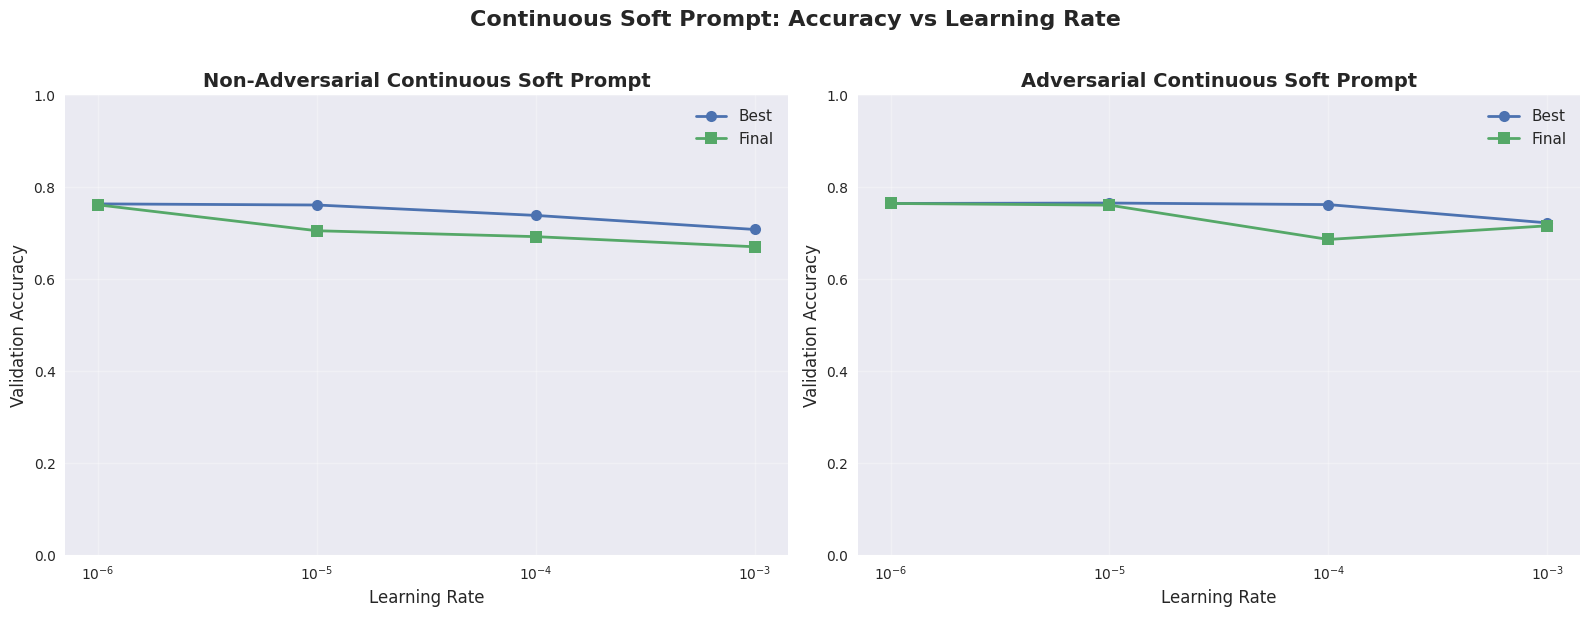

In [18]:
# Comparison plot: Best accuracy vs Learning Rate
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Continuous Soft Prompt: Accuracy vs Learning Rate', fontsize=16, fontweight='bold', y=1.02)

# Non-adversarial
if non_adv_histories:
    ax1 = axes[0]
    lrs = sorted(set(k[1] for k in non_adv_histories.keys()))
    best_accs = []
    final_accs = []
    for lr in lrs:
        for (adv, l, pl), history in non_adv_histories.items():
            if l == lr:
                best_accs.append(max(history['val_acc']))
                final_accs.append(history['val_acc'][-1])
                break
    
    ax1.plot(lrs, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax1.plot(lrs, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax1.set_xlabel('Learning Rate', fontsize=12)
    ax1.set_ylabel('Validation Accuracy', fontsize=12)
    ax1.set_title('Non-Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax1.set_xscale('log')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim([0, 1])

# Adversarial
if adv_histories:
    ax2 = axes[1]
    lrs = sorted(set(k[1] for k in adv_histories.keys()))
    best_accs = []
    final_accs = []
    for lr in lrs:
        for (adv, l, pl), history in adv_histories.items():
            if l == lr:
                best_accs.append(max(history['val_acc']))
                final_accs.append(history['val_acc'][-1])
                break
    
    ax2.plot(lrs, best_accs, marker='o', label='Best', linewidth=2, markersize=8)
    ax2.plot(lrs, final_accs, marker='s', label='Final', linewidth=2, markersize=8)
    ax2.set_xlabel('Learning Rate', fontsize=12)
    ax2.set_ylabel('Validation Accuracy', fontsize=12)
    ax2.set_title('Adversarial Continuous Soft Prompt', fontsize=14, fontweight='bold')
    ax2.set_xscale('log')
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()
